In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
%cd ../..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import configuration
import model_registry
import data.constants as dconst
from data.util import data_get_num_attributes, data_get_num_classes
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification
from evaluation.util import get_data_loader, run_model_on_datasets, separate_distributions
import evaluation.callbacks as ecbs
from metrics import expected_calibration_error
from plot.calibration import plot_calibration
from data.util import label_binarize
from model.density import get_density_model


In [4]:
import umap

In [5]:
debug_dict = torch.load('../citeseer_debug.pt')
debug_dict.keys()

dict_keys(['features_fit', 'features_val', 'features_eval', 'predictions_fit', 'predictions_val', 'predictions_eval', 'auroc_labels', 'auroc_mask'])

In [6]:
debug_dict['predictions_fit'].size(1)

6

In [7]:
density_model = get_density_model(
    density_type='GaussianPerClass',
    covariance='diag',
    regularization=False,
    fit_val=False,
)
density_model.fit(debug_dict['features_fit'], debug_dict['predictions_fit'], debug_dict['features_val'], debug_dict['predictions_val'])

In [8]:
density_means = torch.stack([density_model.means[idx] for idx in range(debug_dict['predictions_fit'].size(1))], 0)
density_means.size()

torch.Size([6, 64])

In [9]:
log_density_eval = density_model(debug_dict['features_eval'])

In [10]:
log_density_fit = density_model(debug_dict['features_fit'])

In [11]:
log_density_val = density_model(debug_dict['features_val'])

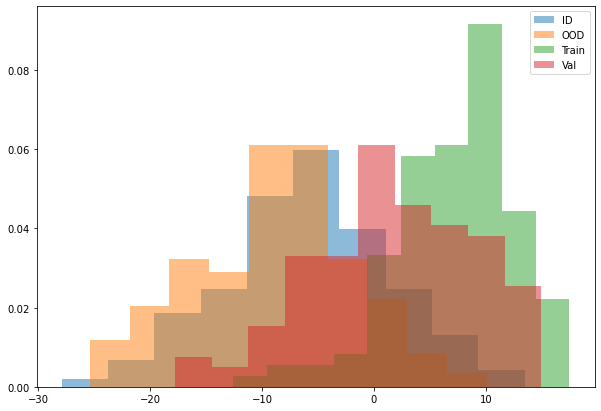

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(log_density_eval[debug_dict['auroc_labels'] == True].numpy(), alpha=.5, density=True, label='ID')
ax.hist(log_density_eval[debug_dict['auroc_labels'] == False].numpy(), alpha=.5, density=True, label='OOD')
ax.hist(log_density_fit.numpy(), alpha=.5, density=True, label='Train')
ax.hist(log_density_val.numpy(), alpha=.5, density=True, label='Val')
ax.legend()

In [13]:
proj = umap.UMAP(random_state = 1337)
proj.fit(torch.cat([
    debug_dict['features_fit'],
    debug_dict['features_val'],
    debug_dict['features_eval'],
], 0).numpy())

UMAP(random_state=1337, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [14]:
features_fit_proj = proj.transform(debug_dict['features_fit'].numpy())

In [15]:
features_val_proj = proj.transform(debug_dict['features_val'].numpy())

In [16]:
features_eval_proj = proj.transform(debug_dict['features_eval'].numpy())

In [17]:
density_means_proj = proj.transform(density_means.numpy())

In [18]:
features_fit_proj.shape

(120, 2)

In [19]:
auroc_labels = debug_dict['auroc_labels'].numpy()

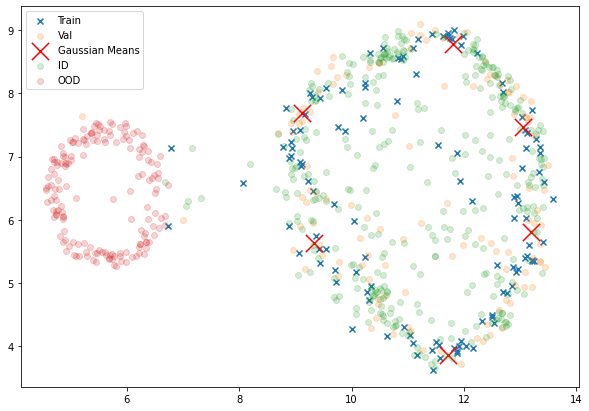

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(features_fit_proj[:, 0], features_fit_proj[:, 1], alpha=1.0, label='Train', marker='x')
ax.scatter(features_val_proj[:, 0], features_val_proj[:, 1], alpha=0.2, label='Val')
ax.scatter(density_means_proj[:, 0], density_means_proj[:, 1], alpha=1.0, label='Gaussian Means', marker='x', s=300, color='red')

ax.scatter(features_eval_proj[:, 0][auroc_labels == True], features_eval_proj[:, 1][auroc_labels == True], alpha=0.2, label='ID')
ax.scatter(features_eval_proj[:, 0][auroc_labels == False], features_eval_proj[:, 1][auroc_labels == False], alpha=0.2, label='OOD')
plt.legend()

In [21]:
log_density_eval_normalized = log_density_eval - log_density_eval.min()

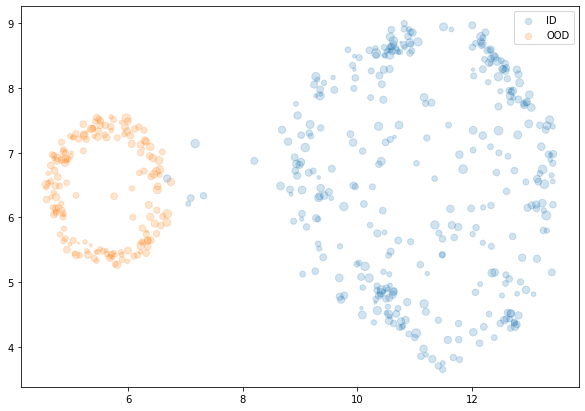

In [22]:
fix, ax = plt.subplots(figsize=(10, 7))
ax.scatter(features_eval_proj[:, 0][auroc_labels == True], features_eval_proj[:, 1][auroc_labels == True], alpha=0.2, 
           s=log_density_eval_normalized.numpy()[auroc_labels == True] * 2,
           label='ID')
ax.scatter(features_eval_proj[:, 0][auroc_labels == False], features_eval_proj[:, 1][auroc_labels == False], alpha=0.2, label='OOD',
          s=log_density_eval_normalized.numpy()[auroc_labels == False] * 2)
ax
ax.legend()

In [23]:
log_density_eval

tensor([-9.8291e-01, -1.1679e+00, -4.8735e+00, -3.5654e+00, -1.6787e+01,
         5.6233e-01, -1.2072e+01,  2.4590e+00, -1.6998e+01, -4.5242e+00,
        -1.7400e+01, -1.8352e+01, -4.9604e+00, -5.9226e-02, -3.1493e+00,
        -1.4205e+01, -3.6305e+00, -5.3000e+00, -3.4517e+00, -2.5382e+01,
        -1.0580e+01, -7.0098e+00, -5.1819e+00, -1.3266e+01,  2.3283e+00,
        -3.6799e+00, -1.5441e+01, -2.0799e+00, -5.3047e+00, -2.0204e+01,
        -1.5622e+00, -9.6073e+00, -3.4967e+00, -5.8611e+00, -2.0086e+00,
        -2.5998e+01, -6.2967e+00, -6.2089e+00, -1.0741e+01, -1.7075e+01,
        -4.8647e+00, -3.3932e+00,  9.8257e+00, -5.4335e-02, -2.2566e+00,
        -9.0697e+00, -1.0788e+01, -6.9769e+00, -6.3464e+00, -7.0153e+00,
        -6.9038e+00, -1.9204e+01, -1.8884e-01, -9.1144e+00, -1.7934e+01,
        -1.0328e+01, -2.7746e+00, -1.5292e+01, -5.6431e-01,  6.9342e-01,
        -2.3394e+01, -1.8204e+01, -2.3059e+00, -8.5012e+00, -6.3733e+00,
        -4.0262e+00, -1.4699e+01, -4.3688e+00,  8.9

In [24]:
from sklearn.neighbors import kneighbors_graph

In [25]:
all_features = torch.cat([debug_dict['features_fit'], debug_dict['features_eval']], 0).numpy()
is_fit = np.zeros(all_features.shape[0]).astype(bool)
is_fit[: debug_dict['features_fit'].size(0) ] = True

In [26]:
all_features.shape, is_fit.shape

((638, 64), (638,))

In [27]:
knn_graph = kneighbors_graph(all_features, n_neighbors=50, mode='distance')
knn_graph.shape


(638, 638)

In [41]:
operator = knn_graph.copy()
operator.data = np.exp(-operator.data)

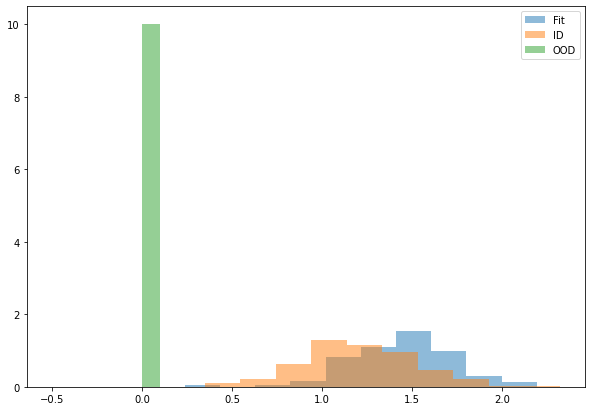

In [42]:
proxy = (operator @ is_fit.astype(int))
proxy_eval = proxy[debug_dict['features_fit'].size(0) : ]
fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(proxy[:debug_dict['features_fit'].size(0)], alpha=.5, label='Fit', density=True)
ax.hist(proxy_eval[auroc_labels == True], alpha=.5, label='ID', density=True)
ax.hist(proxy_eval[auroc_labels == False], alpha=.5, label='OOD', density=True)
ax.legend()


In [43]:
proxy_eval[auroc_labels == False]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [44]:
proxy_eval[auroc_labels == True]

array([1.37065756, 1.05494019, 1.1995998 , 1.65075097, 0.98144964,
       1.10727825, 0.83170742, 1.07718239, 1.23185441, 1.12884562,
       1.16692901, 2.03818415, 1.10812276, 1.0995236 , 1.13476241,
       1.19817699, 1.11197651, 1.36672147, 0.97406974, 0.68244273,
       1.01881952, 1.14251436, 1.46524434, 1.46314556, 0.52908642,
       0.90622984, 0.94007499, 1.18308903, 0.7321245 , 0.99365093,
       1.71865451, 1.29004463, 0.96717874, 1.81758286, 1.13247273,
       1.39711963, 1.27325469, 1.05777039, 1.38596762, 1.10352489,
       1.1661292 , 1.28195582, 1.48534858, 0.637362  , 1.34507754,
       1.47582702, 1.19303462, 1.00308803, 0.95525579, 1.53476495,
       0.96549226, 0.9098862 , 1.31726932, 0.71704914, 1.30895479,
       0.39758687, 0.69431604, 1.05637699, 1.04709365, 0.92527709,
       1.84928814, 1.96911887, 0.89551538, 1.21050774, 1.64327895,
       0.41593686, 1.06308185, 0.75359796, 1.4910309 , 1.39868687,
       1.77688302, 0.51487436, 0.86595763, 1.49582829, 1.57945

In [45]:
proj_no_eval = umap.UMAP(random_state = 1337)
proj_no_eval.fit(torch.cat([
    debug_dict['features_fit'],
    debug_dict['features_val'],
    # debug_dict['features_eval'],
], 0).numpy())

UMAP(random_state=1337, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

## Fit UMAP only to training and validation data

In [46]:
features_fit_proj_no_eval = proj_no_eval.transform(debug_dict['features_fit'].numpy())
features_val_proj_no_eval = proj_no_eval.transform(debug_dict['features_val'].numpy())
features_eval_proj_no_eval = proj_no_eval.transform(debug_dict['features_eval'].numpy())

In [47]:
density_means_proj_no_eval = proj_no_eval.transform(density_means.numpy())

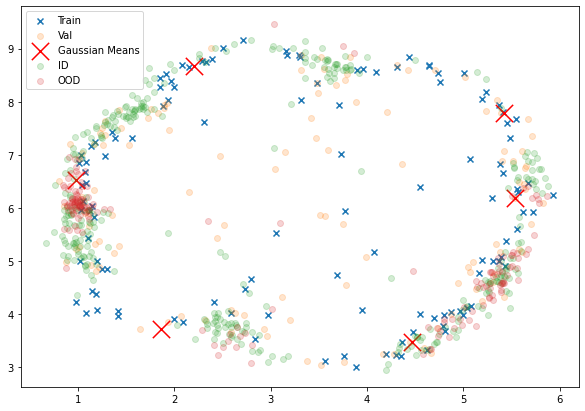

In [48]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(features_fit_proj_no_eval[:, 0], features_fit_proj_no_eval[:, 1], alpha=1.0, label='Train', marker='x')
ax.scatter(features_val_proj_no_eval[:, 0], features_val_proj_no_eval[:, 1], alpha=0.2, label='Val')
ax.scatter(density_means_proj_no_eval[:, 0], density_means_proj_no_eval[:, 1], alpha=1.0, label='Gaussian Means', marker='x', s=300, color='red')

ax.scatter(features_eval_proj_no_eval[:, 0][auroc_labels == True], features_eval_proj_no_eval[:, 1][auroc_labels == True], alpha=0.2, label='ID')
ax.scatter(features_eval_proj_no_eval[:, 0][auroc_labels == False], features_eval_proj_no_eval[:, 1][auroc_labels == False], alpha=0.2, label='OOD')
plt.legend()

## Distances to fit data for single ID and OOD samples

In [36]:
distances_to_fit = torch.cdist(debug_dict['features_fit'], debug_dict['features_eval']).T
distances_to_fit.size()

torch.Size([518, 120])

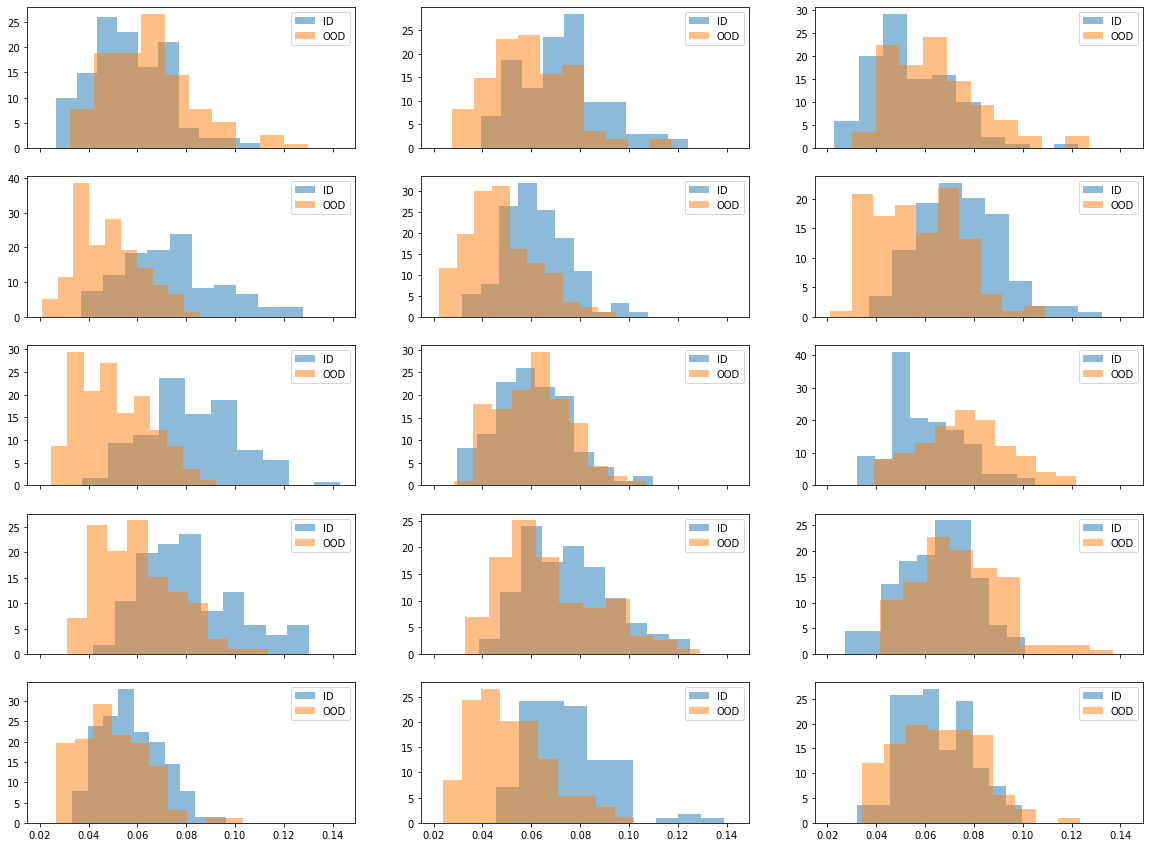

In [37]:

metric = np.exp(-distances_to_fit)

fig, axs = plt.subplots(5, 3, figsize=(20, 15), sharex=True)
for ax in axs.flatten():
    idx_id = np.random.choice(np.arange(auroc_labels.shape[0])[auroc_labels == True])
    idx_ood = np.random.choice(np.arange(auroc_labels.shape[0])[auroc_labels == False])

    ax.hist(metric[idx_id].numpy(), alpha=.5, density=True, label='ID')
    ax.hist(metric[idx_ood].numpy(), alpha=.5, density=True, label='OOD')
    ax.legend()

# Distribution of distances within id and ood

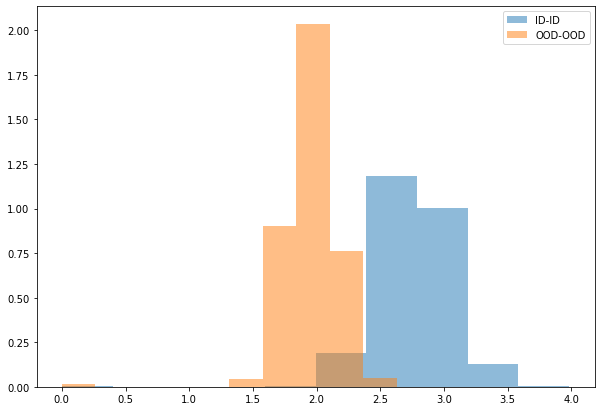

In [38]:
distances_all = torch.cdist(debug_dict['features_eval'], debug_dict['features_eval'])
distances_all.size()

distances_id_id = distances_all[ auroc_labels == True][:, auroc_labels == True]
distances_ood_ood = distances_all[ auroc_labels == False][:, auroc_labels == False]

distances_id_id_flat = np.tril(distances_id_id).flatten()
distances_id_id_flat = distances_id_id_flat[distances_id_id_flat > 0]

distances_ood_ood_flat = np.tril(distances_ood_ood).flatten()
distances_ood_ood_flat = distances_ood_ood_flat[distances_ood_ood_flat > 0]

fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(distances_id_id_flat, alpha=.5, density=True, label='ID-ID')
ax.hist(distances_ood_ood_flat, alpha=.5, density=True, label='OOD-OOD')
ax.legend()
